# Salary Prediction with Linear Regression
We model how **experience**, **education level**, and **skills** influence IT salaries. Linear regression estimates coefficients that show how much the salary changes when a feature increases by one unit. We use **5-Fold Cross-Validation** to obtain reliable accuracy estimates by rotating which fold acts as the validation set.

Columns detected: ['age', 'gender', 'education_level', 'job_title', 'years_of_experience', 'salary']
Using feature columns: ['age', 'years_of_experience', 'education_level', 'job_title', 'gender']
Using target column: salary
Loaded 375 samples
    age  years_of_experience  education_level  job_title  gender
0  32.0                  5.0              0.0      159.0     1.0
1  28.0                  3.0              1.0       17.0     0.0
2  45.0                 15.0              2.0      130.0     1.0
3  36.0                  7.0              0.0      101.0     0.0
4  52.0                 20.0              1.0       22.0     1.0

🔹 Fold 1/5
Fold 1: MSE = nan, R² = nan%
Coefficients (original units):
  age: nan
  years_of_experience: nan
  education_level: nan
  job_title: nan
  gender: nan
  intercept: nan

🔹 Fold 2/5
Fold 2: MSE = nan, R² = nan%
Coefficients (original units):
  age: nan
  years_of_experience: nan
  education_level: nan
  job_title: nan
  gender: nan
  intercept: nan

🔹 F

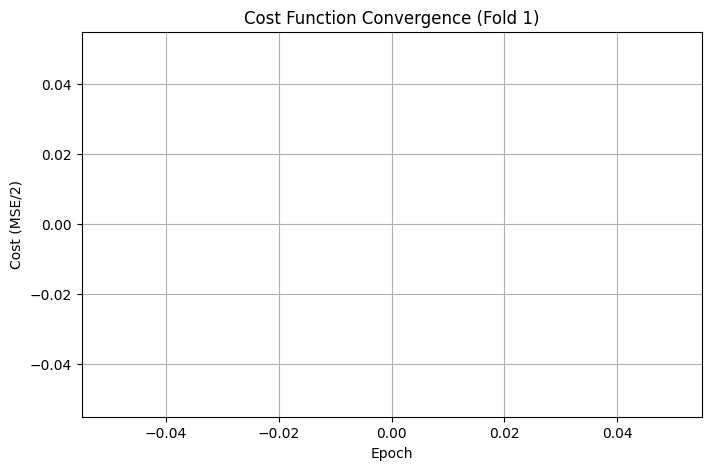

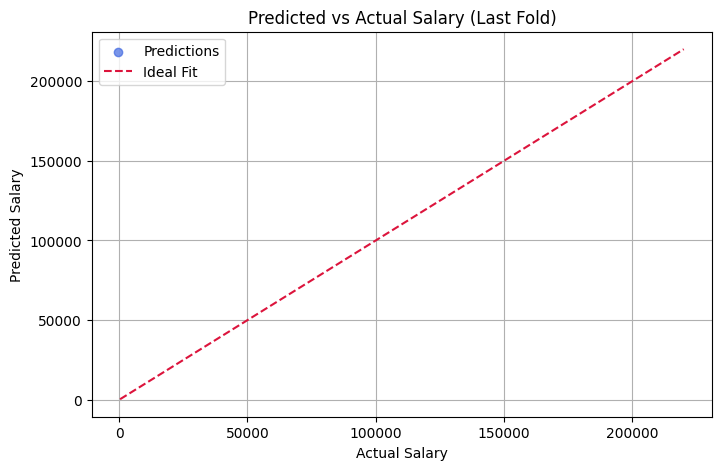

In [ ]:
# ============================================================
# Linear Regression for IT Salary Estimation (From Scratch)
# Features: Age, Experience, Education, Job Title, Gender → Target: Salary
# Evaluation: 5-Fold Cross-Validation with MSE & R²
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# ------------------------------------------------------------
# 1️⃣ Load and inspect dataset
# ------------------------------------------------------------
file_path = "./datasets/Salary_Data_14.xlsx"
df_raw = pd.read_excel(file_path)

# Normalise column names for consistent access
df_raw.columns = df_raw.columns.str.strip().str.lower().str.replace(" ", "_")
print("Columns detected:", df_raw.columns.tolist())

feature_names = [
    "age",
    "years_of_experience",
    "education_level",
    "job_title",
    "gender",
]
target_name = "salary"
missing = [col for col in feature_names + [target_name] if col not in df_raw.columns]
if missing:
    raise KeyError(f"Expected columns missing from dataset: {missing}")

print("Using feature columns:", feature_names)
print("Using target column:", target_name)

features_df = df_raw[feature_names].copy()
target_series = df_raw[target_name].astype(float)

# Encode non-numeric columns (education, job title, gender)
for col in ["education_level", "job_title", "gender"]:
    if not np.issubdtype(features_df[col].dtype, np.number):
        features_df[col] = features_df[col].astype("category").cat.codes.astype(float)

# Drop rows with missing or infinite values to avoid NaNs during training
combined = features_df.copy()
combined[target_name] = target_series
combined = combined.replace([np.inf, -np.inf], np.nan)
rows_before = len(combined)
combined = combined.dropna()
rows_dropped = rows_before - len(combined)
if rows_dropped:
    print(f"Dropped {rows_dropped} rows due to missing values.")

target = combined[target_name].values.astype(float)
X_raw = combined[feature_names].astype(float).values
print(f"Loaded {len(X_raw)} samples for training")
print(combined[feature_names].head())

# ------------------------------------------------------------
# 2️⃣ Cross-validation setup
# ------------------------------------------------------------
alpha = 0.01
epochs = 1200
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []
fold_costs = []
fold = 1


def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def standardise(X_train, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0
    return (X_train - mean) / std, (X_test - mean) / std, mean, std

# ------------------------------------------------------------
# 3️⃣ Gradient Descent per fold
# ------------------------------------------------------------
for train_idx, test_idx in kf.split(X_raw):
    print(f"\n🔹 Fold {fold}/{k_folds}")

    X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]

    X_train_scaled, X_test_scaled, mean_vec, std_vec = standardise(X_train_raw, X_test_raw)

    X_train = add_bias(X_train_scaled)
    X_test = add_bias(X_test_scaled)

    w = np.zeros(X_train.shape[1])
    n = len(y_train)
    cost_history = []

    for _ in range(epochs):
        preds = X_train @ w
        error = preds - y_train
        cost = (1 / (2 * n)) * np.sum(error ** 2)
        cost_history.append(cost)

        gradient = (1 / n) * (X_train.T @ error)
        w -= alpha * gradient

    fold_costs.append(cost_history)

    y_pred = X_test @ w

    mse = np.mean((y_pred - y_test) ** 2)
    ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
    ss_res = np.sum((y_test - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_total)

    mse_scores.append(mse)
    r2_scores.append(r2)

    slopes = w[1:] / std_vec
    intercept = w[0] - np.sum((mean_vec / std_vec) * w[1:])

    # Expose last fold vectors for plotting
    last_w = w
    last_mean = mean_vec
    last_std = std_vec
    last_test_actual = y_test
    last_test_pred = y_pred

    print(f"Fold {fold}: MSE = {mse:.2f}, R² = {r2*100:.2f}%")
    print("Coefficients (original units):")
    for name, slope in zip(feature_names, slopes):
        print(f"  {name}: {slope:.4f}")
    print(f"  intercept: {intercept:.4f}")

    fold += 1

# ------------------------------------------------------------
# 4️⃣ Aggregate metrics
# ------------------------------------------------------------
print("\n✅ Average MSE across folds:", np.mean(mse_scores))
print("✅ Average R² Score across folds: {:.2f}%".format(np.mean(r2_scores) * 100))

# ------------------------------------------------------------
# 5️⃣ Visualisations
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(fold_costs[0])
plt.title("Cost Function Convergence (Fold 1)")
plt.xlabel("Epoch")
plt.ylabel("Cost (MSE/2)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(last_test_actual, last_test_pred, alpha=0.7, color='royalblue', label='Predictions')
line_min = min(last_test_actual.min(), last_test_pred.min())
line_max = max(last_test_actual.max(), last_test_pred.max())
plt.plot([line_min, line_max], [line_min, line_max], color='crimson', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Salary (Last Fold)")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.grid(True)
plt.show()
